# Asset-Liability Management

## Table of Content:
* [1. Introduction](#intro)
* [2. Data Preparation](#data_prep)
    * [2.1 Selecting the Goal Hedging Portfolio (GHP)](#bond_return)
    * [2.2 Selecting the Performance Seeking Portfolio (PSP)](#equity_return)
* [3. Choosing Portfolio by Capital Allocation](#choose_port)
    * [3.1 Simplest Allocator - Fixed Mix](#fixed)
    * [3.2 Floor Allocator](#floor)
    * [3.3 Drawdown Allocator](#dd)
* [4. Appendix - Backtesting with Historical Data](#appendix)

## 1. Introduction <a class="anchor" id="intro"></a>

Asset Liability Management (ALM) is a critical practice in financial management, aimed at ensuring that an institution's assets are structured to meet its future liabilities. This process is particularly vital for pension funds, insurance companies, and banks, where the alignment of assets and liabilities is essential to maintain financial stability and meet long-term obligations. Below are the common steps for the practice:

**Step 1: Understanding Funding Status:**
   - **Funding Ratio ($F_{t}$)**: The funding ratio, calculated as the ratio of assets to liabilities, is a key measure of funding status. A ratio of 100% or more indicates full funding, while a lower ratio signifies underfunding and the need for strategic asset allocation.
   $$F_{t}=A_{t}/L_{t}$$
   - Fully Funded vs. Underfunded: If fully funded, the best strategy is to build a portfolio of immunized bonds that match future liability cash flows. However, most institutions and individuals do not have the assets required to fully fund all future liabilities. 
   - Partial Funding: In these more common scenarios, it's necessary to allocate existing assets between performance-seeking components and goal-hedging components.

**Step 2: Identifying Components of ALM:**
   - **Performance Seeking Portfolio (PSP):** This portfolio involves taking calculated risks to achieve higher returns. The aim is to construct a high Sharpe Ratio portfolio, where the risk taken is adequately compensated by the returns.
   - **Goal Hedging Portfolio (GHP):** This portfolio is designed to protect against downside risks. It typically includes immunized bonds that match future liabilities and are less sensitive to interest rate changes. 

**Step 3: Selecting the PSP:**
   - **Geometric Brownian Motion-Based Portfolios:** Initially, a simple approach using Geometric Brownian motion-based random stock portfolios is employed due to its simplicity. Advanced techniques for constructing PSPs, including portfolio optimization, are covered in a separate repository.

**Step 4: Constructing the GHP:**
   - **Zero Coupon Bonds:** While zero coupon bonds of specific maturities aren't always available, various bonds with maturities ranging from 5 to 30 years can be utilized. Achieving immunity to interest rate changes involves constructing a bond portfolio with a duration matching that of the liabilities, ensuring both respond similarly to interest rate fluctuations. Zero coupon bonds, when available, are ideal for this purpose due to their immunity against interest rate changes when held to maturity. Using the Cox-Ingersoll-Ross (CIR) model, the impact of interest rate fluctuations can be simulated.
   - **Duration Matching:** A crucial measure of a bond's sensitivity to interest rate changes. Macaulay Duration, the weighted average time of cash flows, provides insight into the bond's behavior. Matching the liabilities' duration to the bond portfolio's duration ensures sensitivity alignment, effectively hedging against interest rate risks. Since Macaulay Duration itself reflects sensitivity, Modified Duration calculations are unnecessary.
   - **Bond Price Simulation:** Simulating the prices of coupon-bearing bonds allows for an understanding of how their prices change with fluctuating interest rates. This step focuses on Treasury Bonds to simplify the analysis.

**Step 5: Allocating Capital:**
   - **Risk Budgeting Exercise:** Deciding how much to allocate to the PSP versus the GHP involves assessing risk tolerance and return objectives. This is essentially a risk budgeting exercise, balancing the need for growth with the need for security.
   - **Optimal Allocation Strategy:** Maximising Expected utility of the funding ratio ($\underset{w}{max} E[u(\frac{A_{T}}{L_{t}})]$) with 2 building blocks (PSP, GHP)
   $$\underset{w}{max} E[u(\frac{A_{T}}{L_{t}})]= \frac{\lambda_{PSP}}{\gamma\sigma_{PSP}}w^{PSP}+\beta_{L, GHP}(1-\frac{1}{\gamma})w^{GHP}$$

   where:
   - Lambda ($\lambda$) of the PSP: the Sharpe Ratio of the PSP, increasing $\lambda$ makes PSP more desirable, as it more effectively captures risk premium.
   - Beta ($\beta$) of the LHP: focus on risk management with the liabilities, when $\beta$ is zero, it indicates poor performance in managing risk and tracking liabilities, making it undesirable to hold.
   - Volatility ($\sigma$) of the PSP: lower is preferable as it provides stability for stakeholders and enhances performance
   - Gamma ($\gamma$): a risk aversion parameter, indicates that infinitely risk-averse investors (γ=∞) will avoid investing in the PSP, highlighting the complexity of managing risk aversion in pension funds, where it's treated as a flexible factor.

By integrating these steps into the asset-liability management process, institutions can better ensure their ability to meet future liabilities, optimize their investment strategies, and maintain financial health. This structured approach helps in making informed decisions, balancing the trade-off between seeking higher returns and protecting against potential risks.

Below sections will focus on demonstrating different capital allocation techniques (step 5) and evaluate their performance.

In [42]:
# import libraries
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Data Preparation <a class="anchor" id="data_prep"></a>

The Monte Carlo simulation for both the duration-matched bond portfolio and the stock portfolio is conducted with 5000 scenarios.

In [43]:
# set the scenario parameters
n_scenarios =  5000

### 2.1 Selecting the Goal Hedging Portfolio (GHP) <a class="anchor" id="bond_return"></a>

Assume a 10 year bond with an initial rate of 3% coupon rate and it is paid monthly. Below function generates the prices of a duration matched bond portfolio with random interest rates $dr_{t}$ which simulate with the Cox-Ingersoll-Ross (CIR) model. A mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ (scaling factor) is the volatility parameter, $dt$ is the amount of time that has passed, $dW_{t}$ is a random normal variable.

It's a mean reversion model describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value (shock) that depends on the volatility parameter.

Thus, it is possible to start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If the ${\sqrt  {r_{t}}}$ term is eliminated, it will be the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

Below function assumes annualized rates for parameters speed (a) = 0.05, long-term mean rate (b) = 3%, and initial rate (r_0) = 3%. It generates interest rate (**rates**) with random shocks, adjusting rates over each time step based on the CIR model equation. 

Additionally, it computes corresponding prices (**zc_prices**) using the CIR model for interest rate-based pricing, ensuring consistency with interest rate changes over the specified time horizon, and can be utilized to generate the movement of bond prices (proxied by zero coupon bond) implied by the generated interest rate, using the following equations.

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$

In [44]:
# generate the price of bond portfolio with CIR model
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
# compute return of bond portfolio - ghp
rets_zc = zc_prices.pct_change().dropna()

### 2.2 Selecting the Performance Seeking Portfolio (PSP) <a class="anchor" id="equity_return"></a>

For simplicity, Geometric Brownian Motion (random walk process) is used to simulate stock prices through Monte Carlo simulations following below equation:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

Assume stocks return an average of 7% per year with a 15% volatility. Below functions takes parameters such as drift (mu=0.07), volatility (sigma=0.15), and time granularity (dt, steps_per_year=12) to generate scenarios over a specified number of years (n_years=10) and paths (n_scenarios=5000), starting from an initial value (s_0=100). The output is a numpy array representing the simulated stock prices (**price_eq**).

In [45]:
# generate the price of equity portfolio with GBM model
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
# compute return of equity portfolio - psp
rets_eq = price_eq.pct_change().dropna()

## 3. Choosing Portfolio by Capital Allocation <a class="anchor" id="choose_port"></a>

### 3.1 Simplest Allocator - Fixed Mix <a class="anchor" id="fixed"></a>

The allocator's function is to generate a time series of weights for asset allocation. The simplest allocator, demonstrated below, allocates a fixed fraction to the first portfolio and the remainder to the second. In this project, a 70-30 Stock-Bond mix is implemented.

The fixedmix_allocator function produces a time series of fixed allocations between the Performance Seeking Portfolio (PSP) and the Goal Hedging Portfolio (GHP) across multiple scenarios. It returns a DataFrame with constant weights (w1) for the PSP throughout the entire time period and for all scenarios.

In [46]:
# build a 70-30 stock bond mix portfolio
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)

### 3.2 Floor Allocator <a class="anchor" id="floor"></a>

The floor_allocator function applies a dynamic risk budget to allocate investments between the Performance Seeking Portfolio (PSP) and the Goal Hedging Portfolio (GHP) to maximize exposure to the PSP's upside while ensuring the portfolio value does not fall below a certain target minimum floor (0.75). It uses a Constant Proportion Portfolio Insurance (CPPI) strategy, investing a multiple of the cushion (the difference between the account value and the floor value) in the PSP. The function returns a DataFrame with the same shape as the input returns, representing the weights allocated to the PSP over time.

In the following, different multipliers ($m$) are used to run the backtest and evaluate performance when a higher proportion of the cushion is allocated to the PSP. A higher multiplier increases exposure to the PSP, potentially enhancing returns but also increasing risk. Monthly rebalancing is applied in the project.

In [47]:
# backtest the floor allocator with different floor levels
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
# use m = 1, only put the cushion into PSP
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)

### 3.3 Drawdown Allocator <a class="anchor" id="dd"></a>

The drawdown_allocator function dynamically allocates investments between the Performance Seeking Portfolio (PSP) and the Goal Hedging Portfolio (GHP) to maximize PSP exposure while preventing the portfolio value from exceeding a specified maximum drawdown (maxdd). It employs a Constant Proportion Portfolio Insurance (CPPI) strategy, investing a multiple of the cushion (the difference between the current account value and the floor value, which is based on the previous peak value) in the PSP. 

Because the allocator ensures that the portfolio cannot drop below the drawdown at any point, bonds, including zero-coupon bonds, are unsuitable due to potential price drops. Instead, the allocator uses cash (with a duration of zero) to maintain the required stability. The function returns a DataFrame with the same shape as the input returns, representing the weights allocated to the PSP over time.

In [48]:
# backtest the drawdown allocator with maxdd levels at 25%
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

In [49]:
# combine all the results into a dataframe
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.34,1.95,1.74,1.92,1.61,1.93,1.93,1.62
std,0.00,0.95,0.58,0.95,0.42,0.95,0.96,0.53
p_breach,NaN,0.04,0.01,NaN,NaN,0.00,0.03,NaN
e_short,NaN,0.12,0.07,NaN,NaN,0.00,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The terminal_stats function generates summary statistics for the terminal values of investments per dollar across multiple scenarios. It calculates the final wealth (its mean and volatility), the probability of falling below a specified floor, the probability of exceeding a specified cap, the average shortfall below the floor, and the average surplus above the cap.

From the provided table, it's evident that the floor allocation strategy, particularly with a multiplier of 1, exhibits an option-like behavior. This strategy sacrifices some upside potential, as indicated by a lower mean return (1.62 compared to 1.96 for equities), in exchange for avoiding breaches (0% probability) and the expected shortfall (13%). It also has the lowest volatility among all allocation.

This risk management approach ensures a more predictable outcome and protects against significant downside, aligning with the goal of minimizing risk while still participating in potential market gains.

## 4. Appendix: Backtesting with Historical Data <a class="anchor" id="appendix"></a>

This section aims to expand the scope of the project by applying capital allocation techniques to the 30 industry portfolios obtained from the Kenneth French website, focusing on the period from 2014 until March 2024, spanning a 9-year timeframe. The project will apply the drawdown allocator and examine its performance. 

/Users/jonathanho/Desktop/ALM/edhec_risk_kit.py:86: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("data/ind30_m_nfirms.csv",
/Users/jonathanho/Desktop/ALM/edhec_risk_kit.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("data/ind30_m_size.csv",
/Users/jonathanho/Desktop/ALM/edhec_risk_kit.py:59: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ind = pd.read_csv("data/ind30_m_vw_rets.csv",


<Axes: >

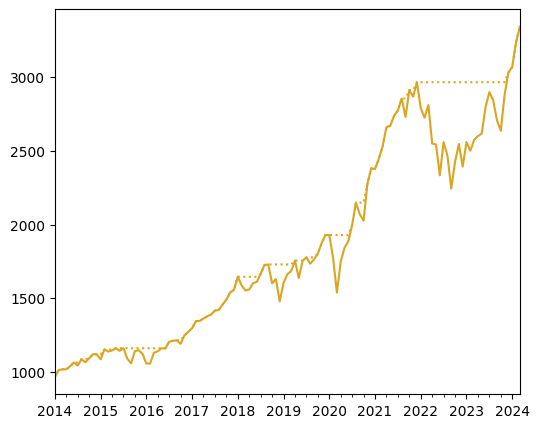

In [50]:
# total market index
rets_tmi =  erk.get_total_market_index_returns()["2014":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(6,5), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

<Axes: >

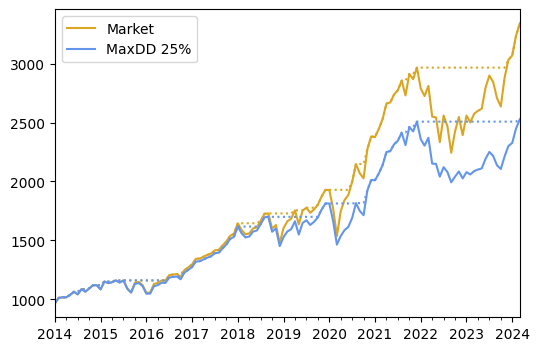

In [51]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(6,4), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [52]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.124930,0.155992,-0.328575,3.723806,0.066344,0.092371,0.592138,-0.243500
MaxDD,0.094746,0.130783,-0.653504,4.237348,0.059304,0.084353,0.481694,-0.205438


The table compares the performance metrics of two investment strategies: "Market" and "Max Drawdown" (MaxDD): 

- The "Market" strategy achieves a higher annualized return of 12.49% but exhibits greater volatility with an annualized volatility of 15.60%. 
- In contrast, the "Max Drawdown" strategy offers a lower return of 9.47% but experiences less volatility, with an annualized volatility of 13.08%. 
- Despite its lower return, the "Max Drawdown" strategy demonstrates a more resilient performance during market downturns, as evidenced by its lower maximum drawdown of -20.54% compared to -24.35% for the "Market" strategy. 

Consequently, investors seeking reduced risk exposure may find the "Max Drawdown" strategy more appealing, while those prioritizing higher returns may opt for the "Market" strategy despite its greater volatility.